# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, models
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
train_transforms = transforms.Compose([
                                transforms.RandomResizedCrop(224),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ToTensor(),
                                #inactivate for data set exploration
                                transforms.Normalize([0.485, 0.456, 0.406], 
                                                     [0.229, 0.224, 0.225])
                            ])
 

test_transforms = transforms.Compose([
                                transforms.RandomResizedCrop(224),
                                transforms.ToTensor(),
                                #inactivate for data set exploration
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])
                            ])
    

# Create training set and define training dataloader
trainset = torchvision.datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=True, transform=train_transforms )
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50, shuffle=True)
print(f"size trainloader: {len(trainloader.dataset)}")

dataiter = iter(trainloader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

# Create test set and define test dataloader
testset = torchvision.datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=False, transform=test_transforms )
testloader = torch.utils.data.DataLoader(testset, batch_size=50, shuffle=True)
print(f"size testloader: {len(testloader.dataset)}")

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 74720942.58it/s]


Extracting /home/student/.pytorch/CIFAR10_data/cifar-10-python.tar.gz to /home/student/.pytorch/CIFAR10_data/
size trainloader: 50000
<class 'torch.Tensor'>
torch.Size([50, 3, 224, 224])
torch.Size([50])
Files already downloaded and verified
size testloader: 10000


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

show 5 of train set


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse


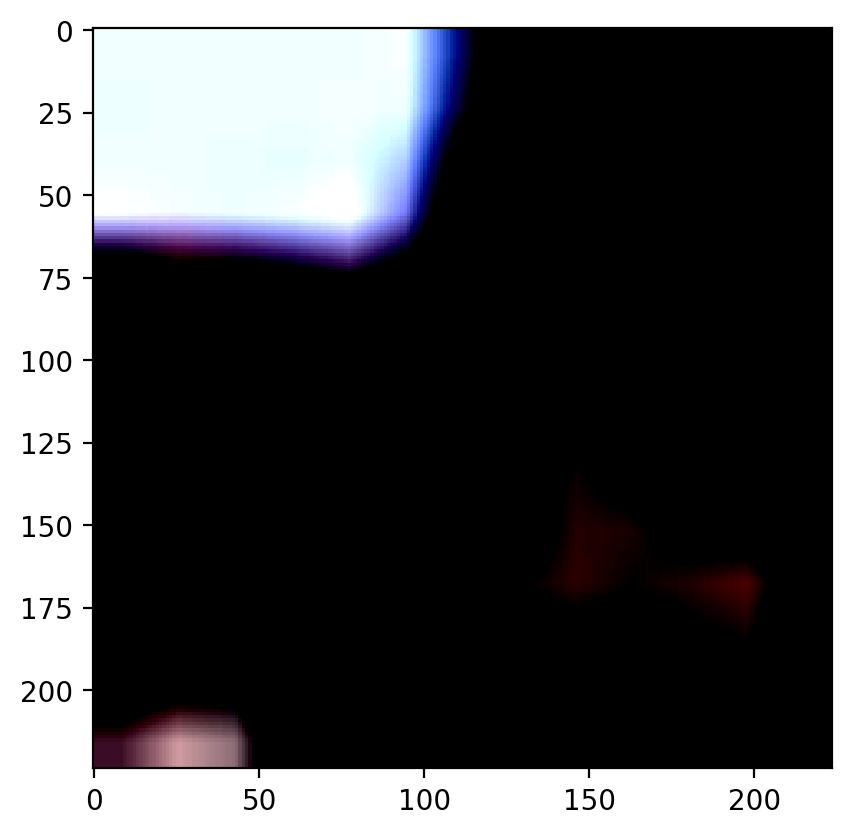

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane


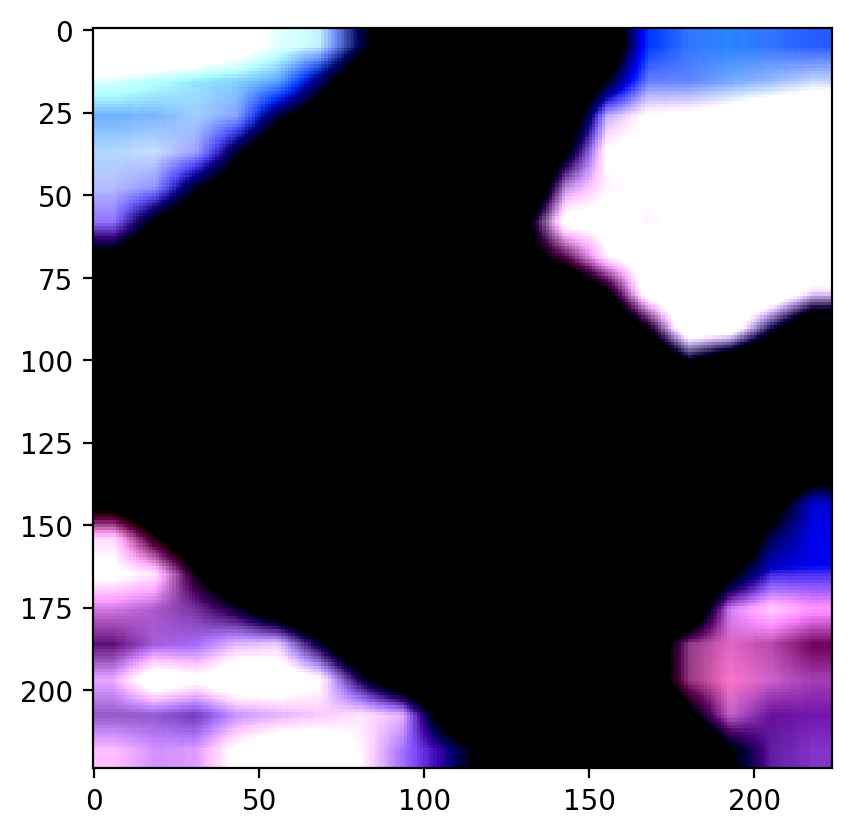

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


bird


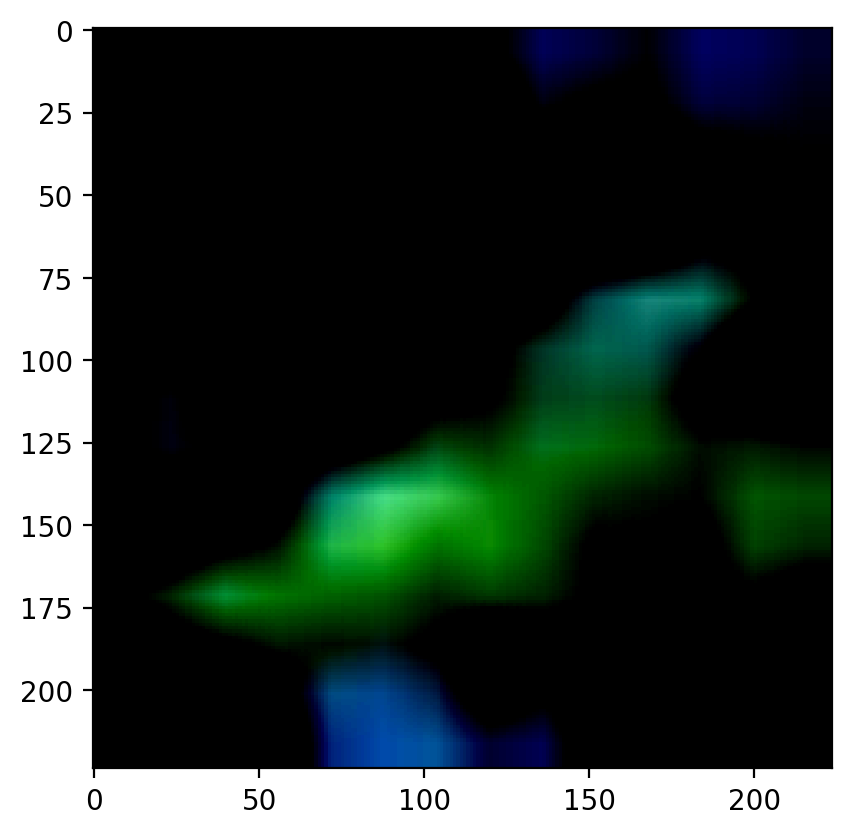

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse


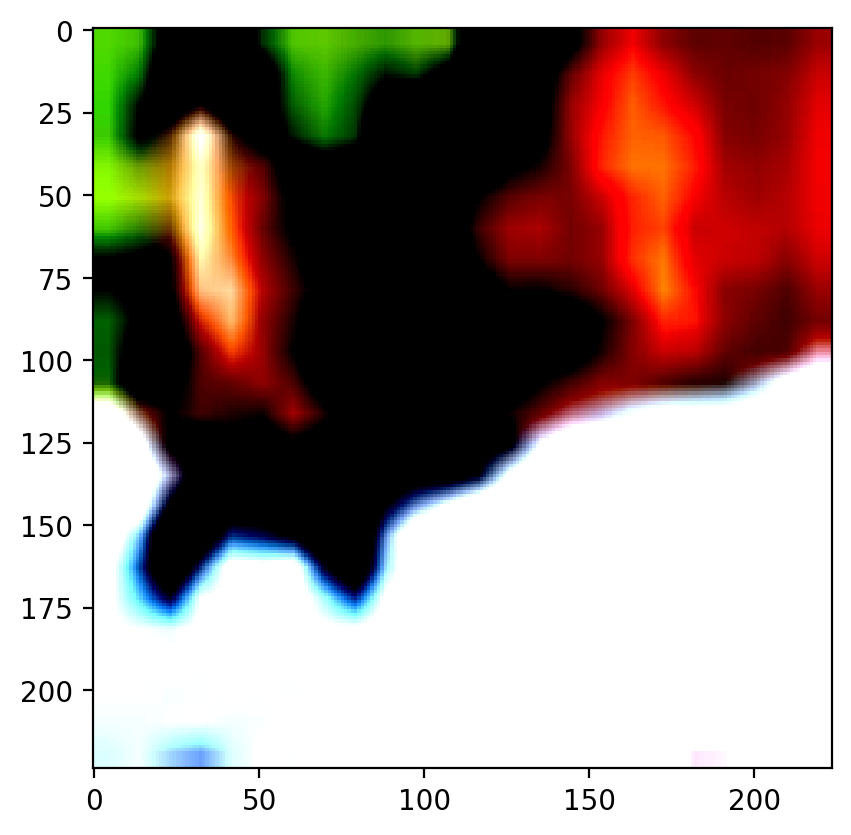

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


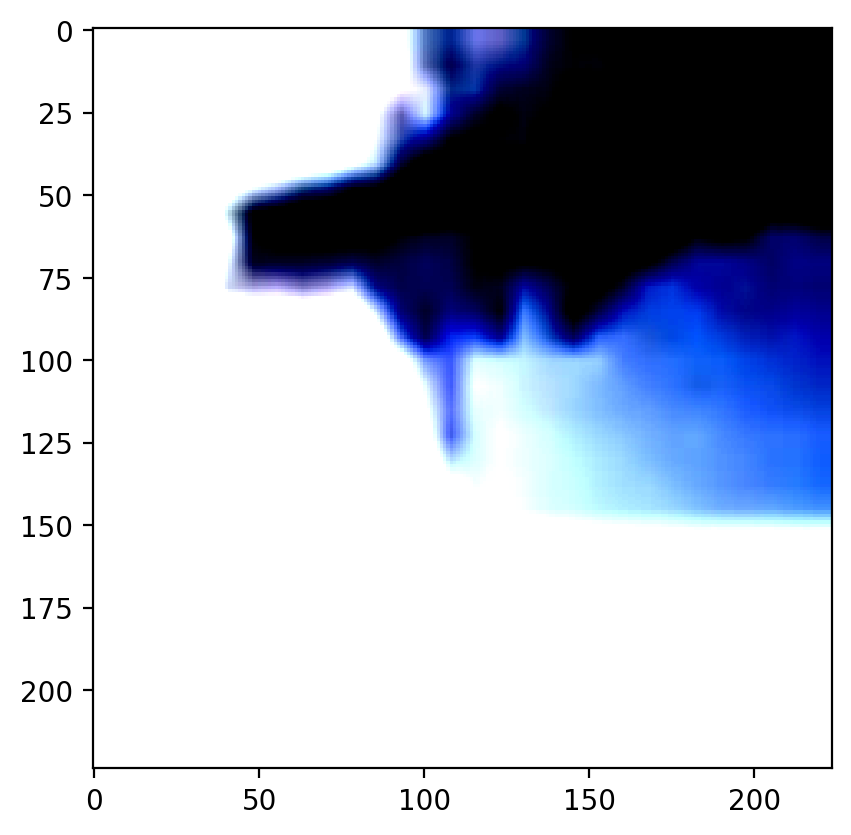

show 5 of test set


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dog


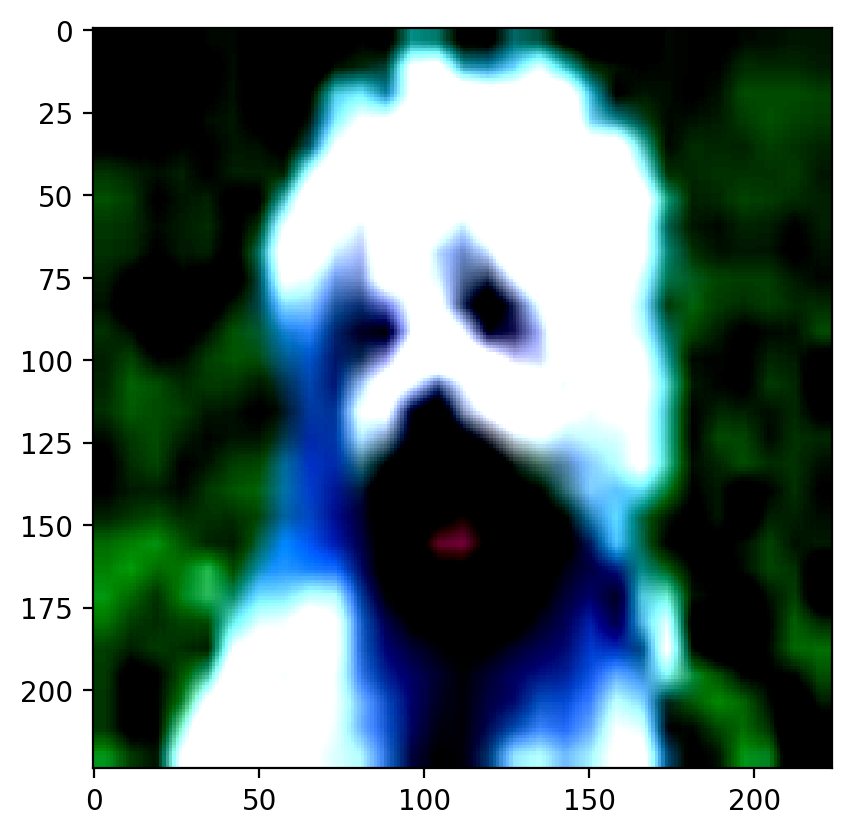

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


deer


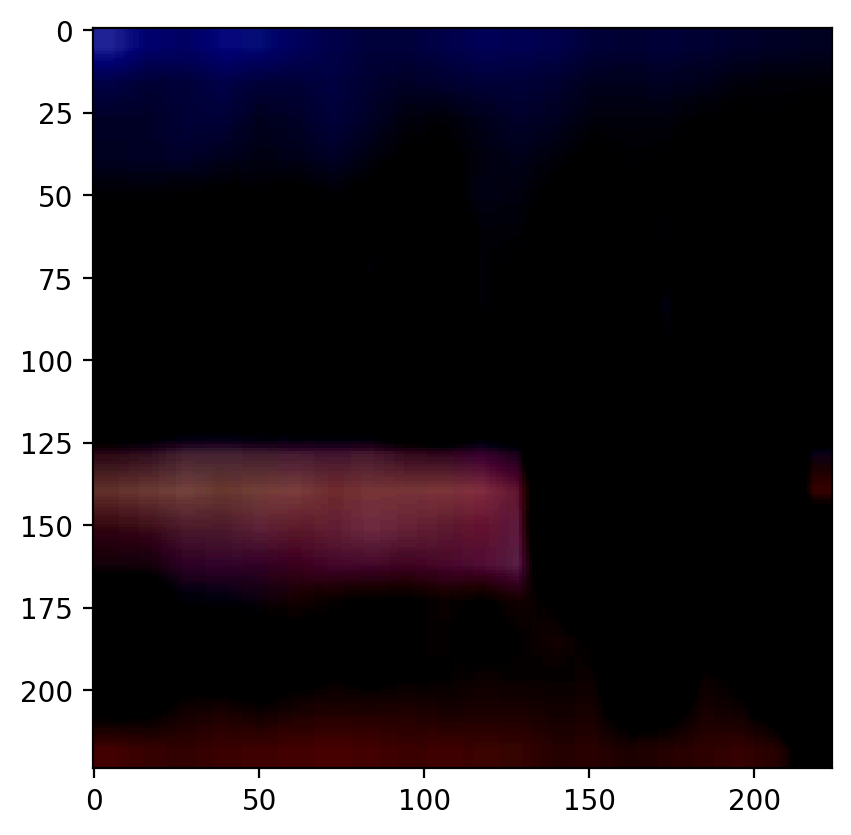

truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


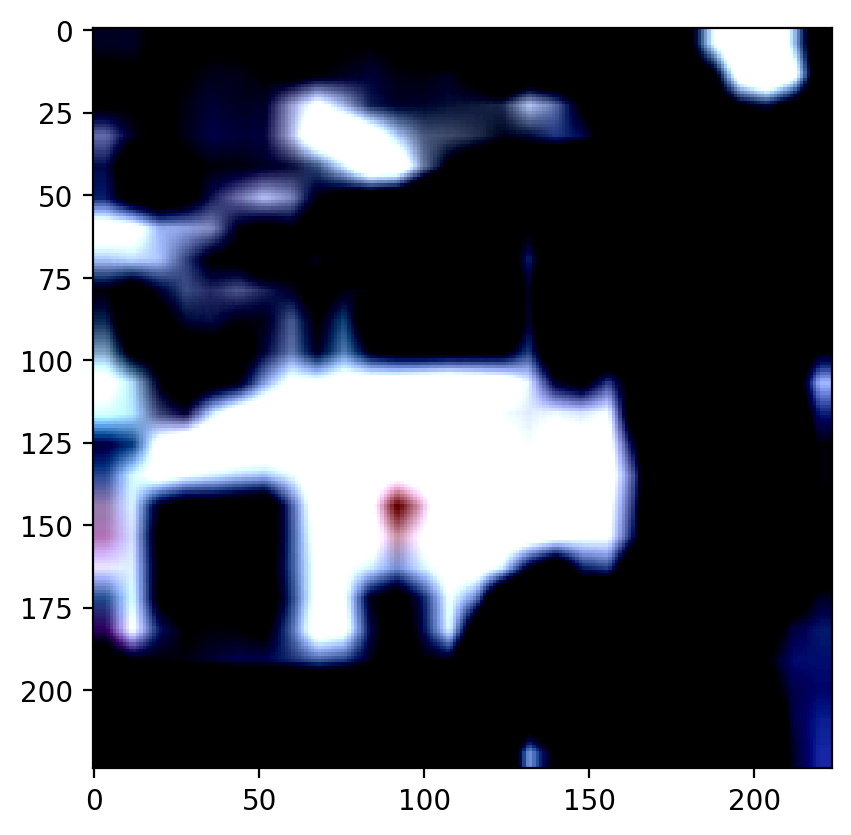

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


frog


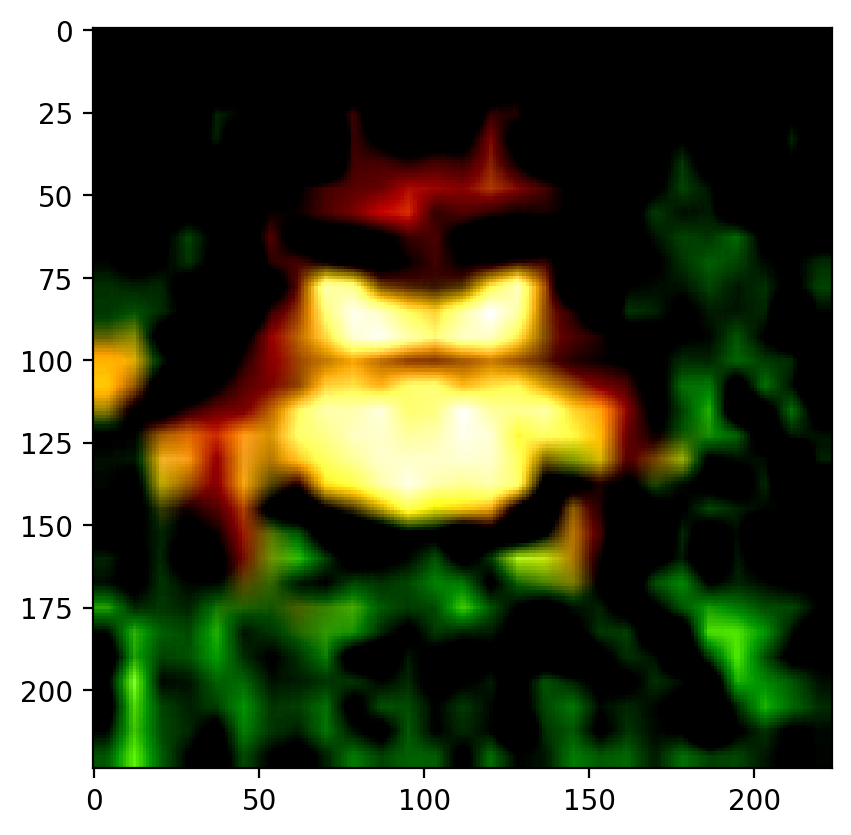

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


car


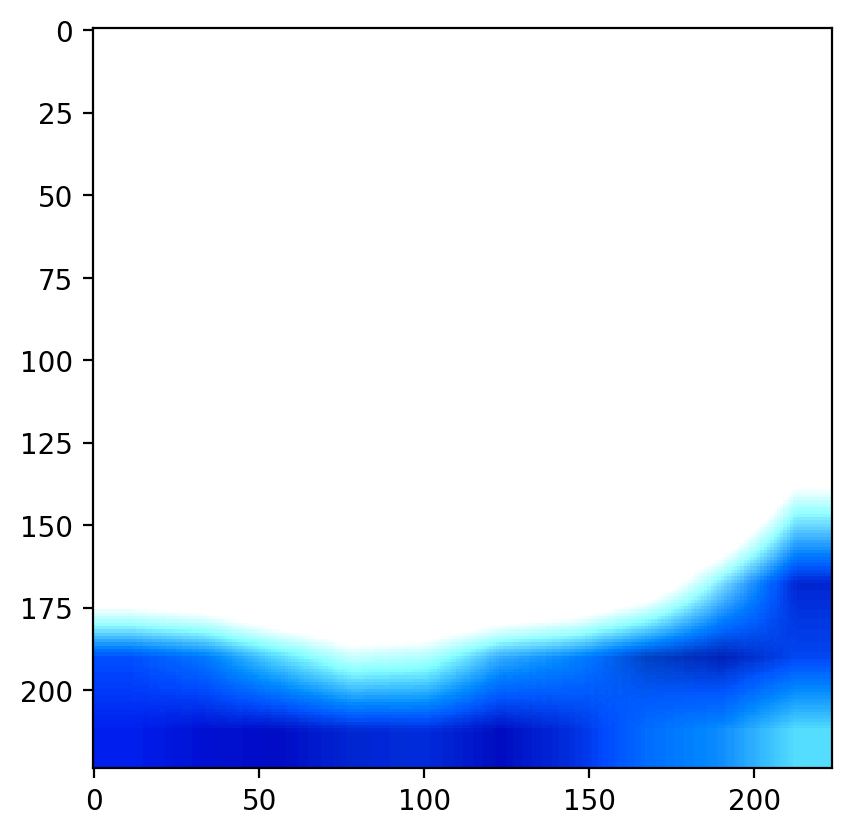

In [4]:
#imshow(images[15], normalize=False)
print("show 5 of train set")
show5(trainloader)
print("show 5 of test set")
show5(testloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.dropout(x)
        x = F.relu(self.fc3(x))
        x = F.dropout(x)
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [6]:
# use pre-trained model
model = models.densenet121(pretrained=True)
model

# freeze parameters (don't backprop through pre-trained model)
for param in model.parameters():
    param.requires_grad = False

model.classifier = Classifier()

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003) # train the classifier parameters only, not the model params (frozen)
#optimizer = optim.Adam(model.parameters(), lr=0.003) 
#optimizer = optim.SGD(model.parameters(), lr=0.003)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/student/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 162MB/s] 


In [7]:
import torch
from torch import nn
import torch.nn.functional as F


class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input layer
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
        
        '''
        super().__init__()
        # Input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

def validation(model, testloader, criterion):
    accuracy = 0
    test_loss = 0
    for images, labels in testloader:

        images = images.resize_(images.size()[0], 784)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ## Calculating the accuracy 
        # Model's output is log-softmax, take exponential to get the probabilities
        ps = torch.exp(output)
        # Class with highest probability is our predicted class, compare with true label
        equality = (labels.data == ps.max(1)[1])
        # Accuracy is number of correct predictions divided by all predictions, just take the mean
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    return test_loss, accuracy


In [8]:
# load model classifier unchanged continue training on (new) data or with modified optimiser (learning rate)
from collections import OrderedDict

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.densenet121(pretrained=True)
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(checkpoint['input_size'], checkpoint['hidden_layers'][0])),
                          ('relu1', nn.ReLU()),
                          ('dropout1', nn.Dropout(0.2)),
                          ('fc2', nn.Linear(checkpoint['hidden_layers'][0], checkpoint['hidden_layers'][1])),
                          ('relu2', nn.ReLU()),
                          ('dropout2', nn.Dropout(0.2)),
                          ('fc3', nn.Linear(checkpoint['hidden_layers'][1], checkpoint['hidden_layers'][2])),
                          ('relu3', nn.ReLU()),
                          ('dropout3', nn.Dropout(0.2)),
                          ('fc4', nn.Linear(checkpoint['hidden_layers'][2], checkpoint['output_size'])),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    model.classifier = classifier
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

model = load_checkpoint('checkpoint_3.pth')
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003) # train the classifier parameters only, not the model params (frozen)
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [9]:
import time

# Use GPU if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
model.to(device)
        
epochs = 4
steps = 0
running_loss = 0
print_every = 250

train_losses, test_losses = [], []

for epoch in range(epochs):
    print("Starting  Epoch ...")
    print(f"size trainloader: {len(trainloader.dataset)}") 
    running_loss = 0

    for i, (images, labels) in enumerate(trainloader):
        steps += 1
        images, labels = images.to(device), labels.to(device)
        
        logps = model.forward(images)
        loss = criterion(logps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()

            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            train_losses.append(running_loss/print_every)
            test_losses.append(test_loss/len(testloader))
            
            print("Epoch: {}/{}.. ".format(epoch+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
                        
            running_loss = 0    
            model.train()

        
        
        # next steps decrease learning rate and further train loaded model + maybe modify data (s. a.)

Starting  Epoch ...
size trainloader: 50000
Epoch: 1/4..  Training Loss: 1.476..  Test Loss: 1.235..  Test Accuracy: 0.573
Epoch: 1/4..  Training Loss: 1.454..  Test Loss: 1.217..  Test Accuracy: 0.586
Epoch: 1/4..  Training Loss: 1.446..  Test Loss: 1.335..  Test Accuracy: 0.538
Epoch: 1/4..  Training Loss: 1.429..  Test Loss: 1.247..  Test Accuracy: 0.558
Starting  Epoch ...
size trainloader: 50000
Epoch: 2/4..  Training Loss: 1.425..  Test Loss: 1.232..  Test Accuracy: 0.583
Epoch: 2/4..  Training Loss: 1.442..  Test Loss: 1.259..  Test Accuracy: 0.558
Epoch: 2/4..  Training Loss: 1.433..  Test Loss: 1.263..  Test Accuracy: 0.552
Epoch: 2/4..  Training Loss: 1.416..  Test Loss: 1.234..  Test Accuracy: 0.570
Starting  Epoch ...
size trainloader: 50000
Epoch: 3/4..  Training Loss: 1.413..  Test Loss: 1.261..  Test Accuracy: 0.564
Epoch: 3/4..  Training Loss: 1.405..  Test Loss: 1.171..  Test Accuracy: 0.589
Epoch: 3/4..  Training Loss: 1.418..  Test Loss: 1.184..  Test Accuracy: 0.595

Plot the training loss (and validation loss/accuracy, if recorded).

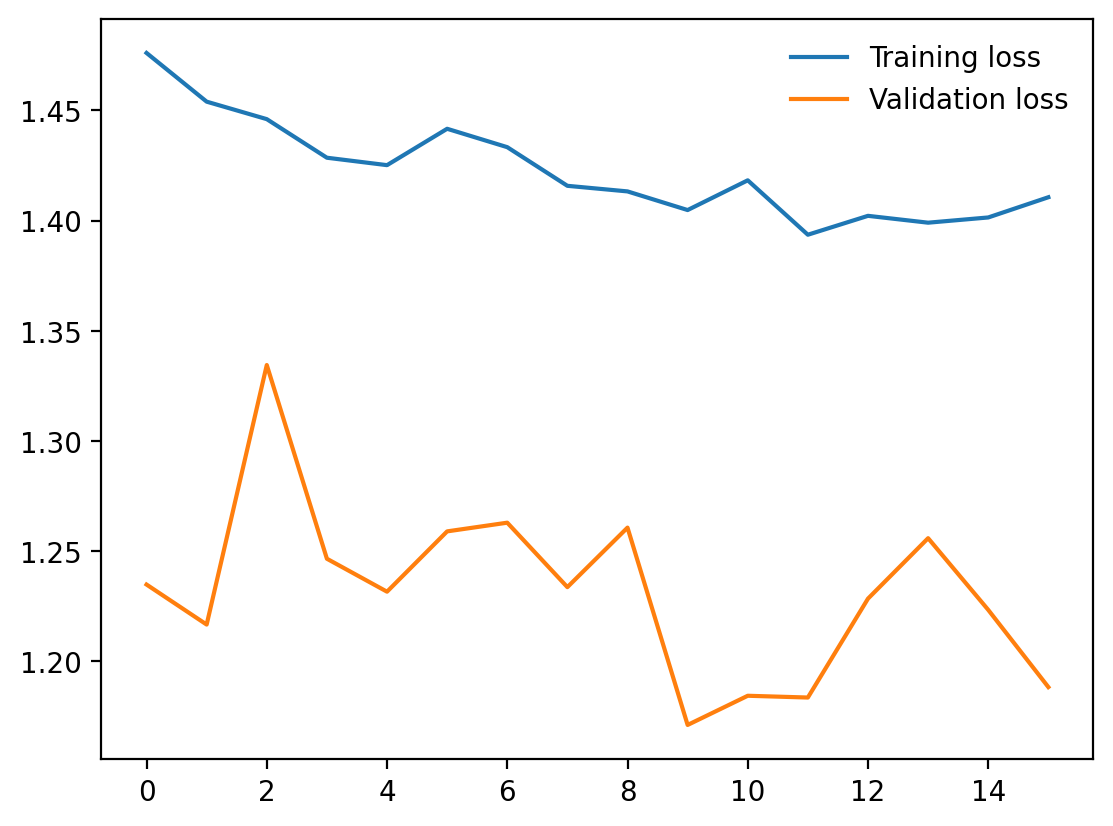

In [10]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)  

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [12]:
inputs, labels = next(iter(testloader))

print(type(inputs))
print(inputs.shape)
print(labels.shape)

# Get the class probabilities
m = model(inputs)
ps = torch.exp(m)

# check shape
print(ps.shape)

# Look at the most likely classes for the first 10 examples
top_p, top_class = ps.topk(1, dim=1)
print(top_class[:10,:])

equals = top_class == labels.view(*top_class.shape)

accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

<class 'torch.Tensor'>
torch.Size([50, 3, 224, 224])
torch.Size([50])


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

## Saving your model
Using `torch.save`, save your model for future loading.

In [11]:
print("model: \n\n", model, '\n')
print("state dict keys: \n\n", model.state_dict().keys())

# save model
#torch.save(model.state_dict(), 'checkpoint.pth')
checkpoint = {'input_size': 1024,
              'output_size': 10,
              'hidden_layers': [256,128,64],
              'state_dict': model.state_dict()}

#torch.save(checkpoint, 'checkpoint.pth') # accuracy 40.xxxx%
#torch.save(checkpoint, 'checkpoint_2.pth') # accuracy 46.00000083446503%
#torch.save(checkpoint, 'checkpoint_3.pth') # accuracy 51.xxx%
torch.save(checkpoint, 'checkpoint_4.pth') # accuracy 


model: 

 DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?



**Double click this cell to modify it**



## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).